In [1]:
%autosave 0
from IPython.core.display import HTML, display
display(HTML('<style>.container { width:100% !important; } </style>'))

Autosave disabled


# Logistic Regression

In [2]:
import numpy as np

We need to define the sigmoid function $S(t) := \large \frac{1}{1 + \exp(-t)}$.

In [3]:
def sigmoid(t):
    return 1.0 / (1.0 + np.exp(-t))

As we are using NumPy to compute $\exp(t)$, we can feed this function with an array to compute the sigmoid function for every element of a vector:

In [4]:
sigmoid(np.array([-1.0, 0.0, 1.0]))

array([0.26894142, 0.5       , 0.73105858])

Next, we define the natural logarithm of the sigmoid function.  If we implement this as <tt>log(sigmoid(t))</tt> we will get overflow issues for negative values of $t$ such that $t < -1000$ as the expression <tt>np.exp(-t)</tt> will overflow. 

In [5]:
np.exp(1000)

inf

In [6]:
np.exp(100)

2.6881171418161356e+43

On the other hand, for $t < -100$ we have that $1 + \exp(-t) \approx \exp(-t)$:

In [7]:
1 + np.exp(-(-100)) == np.exp(-(-100))

True

Therefore, if $t < -100$ we have:
$$ 
\begin{array}{lcl}
         \ln\left(\large\frac{1}{1+\exp(-t)}\right) 
  & = & -\ln\bigl(1+\exp(-t)\bigr) \\
  & \approx & -\ln\bigl(\exp(-t)\bigr)  \\
  & = & t
\end{array}
$$
Hence $\ln\bigl(S(t)\bigr) \approx t$ for $t < -100$. The following implementation uses this approximation.

In [8]:
def logSigmoid(t):
    if t > -100:
        return -np.log(1.0 + np.exp(-t))
    else:
        return t

The function $\texttt{ll}(\textbf{X}, \textbf{y},\textbf{w})$ is mathematically defined as follows:
$$\ell\ell(\mathbf{X},\mathbf{y},\mathbf{w}) = 
 \sum\limits_{i=1}^N \ln\Bigl(S\bigl(y_i \cdot(\mathbf{x}_i \cdot \mathbf{w})\bigr)\Bigr) =
 \sum\limits_{i=1}^N L\bigl(y_i \cdot(\mathbf{x}_i \cdot \mathbf{w})\bigr)
$$
The arguments $\textbf{X}$, $\textbf{y}$, and $\textbf{w}$ are interpreted as follows:
<ul>
    <li> $\textbf{X}$ is the feature matrix, $\textbf{X}[i]$ is the $i$-th feature vector.
         It is assumed that $\textbf{X}[i][0]$ is 1.0 for all $i$.
    </li>
    <li> $\textbf{y}$ is the output vector, $\textbf{y}[i] \in \{-1,+1\}$ for all $i$.</li> 
    <li> $\textbf{w}$ is the weight vector.</li>
</ul>
$\texttt{ll}(\textbf{X}, \textbf{y},\textbf{w})$ computes the <font color="blue">likelihood</font> of the weight vector $\textbf{w}$
given the observations $\textbf{X}$ and $\textbf{y}$.

In [9]:
def ll(X, y, w):   
    return np.sum([logSigmoid(y[i] * (X[i] @ w)) for i in range(len(X))])

The function $\mathtt{gradLL}(\mathbf{x}, \mathbf{y}, \mathbf{w})$ computes the gradient of
the log-lokelihood according to the formula
$$ \frac{\partial\quad}{\partial\, w_j}\ell\ell(\mathbf{X},\mathbf{y};\mathbf{w}) =
   \sum\limits_{i=1}^N y_i \cdot x_{i,j} \cdot  S(-y_i \cdot \mathbf{x}_i \cdot \mathbf{w}).
$$
The different components of this gradient are combined into a vector.
The arguments are the same as the arguments to the function <tt>ll</tt> that computes the log-likelihood.

In [10]:
def gradLL(X, y, w):
    Gradient = []
    for j in range(len(X[1])):
        L = [y[i]*X[i][j]*sigmoid(-y[i] *(X[i] @ w)) for i in range(len(X))]
        Gradient.append(sum(L))
    return np.array(Gradient)

The data we want to investigate is stored in the file `'exam.csv'`.  The first column of this file is an integer from the set $\{0,1\}$.  The nuber is $0$ if the corresponding student has failed the exam and is $1$ otherwise.  The second column is a floating point number that lists the number of hours that the student has studied.

In [11]:
import csv

In [12]:
with open('exam.csv') as file:
    reader = csv.reader(file, delimiter=',', skipinitialspace=True)
    count  = 0  # line count
    Pass   = []
    Hours  = []
    for row in reader:
        if count != 0:  # skip header
            Pass .append(float(row[0]))
            Hours.append(float(row[1]))
        count += 1

To proceed, we will plot the data points.  To this end we transform the lists `Pass` and `Hours` into numpy arrays.

In [13]:
y = np.array(Pass)
x = np.array(Hours)

In [14]:
import matplotlib.pyplot as plt
import seaborn           as sns

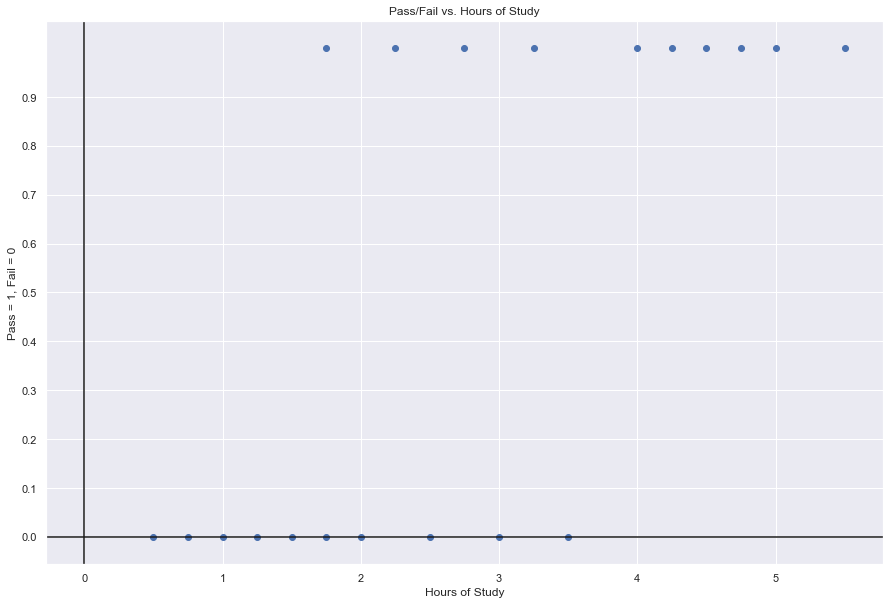

In [15]:
plt.figure(figsize=(15, 10))
sns.set(style='darkgrid')
plt.title('Pass/Fail vs. Hours of Study')
plt.axvline(x=0.0, c='k')
plt.axhline(y=0.0, c='k')
plt.xlabel('Hours of Study')
plt.ylabel('Pass = 1, Fail = 0')
plt.yticks(np.arange(-0.0, 1.0, step=0.1))
plt.scatter(x, y, color='b')

The number of students is stored in the variable `n`.

In [16]:
n = len(y)
n

20

We have to turn the vector `x` into the feature matrix `X`.

In [17]:
X = np.reshape(x, (n,1))
X

array([[0.5 ],
       [0.75],
       [1.  ],
       [1.25],
       [1.5 ],
       [1.75],
       [1.75],
       [2.  ],
       [2.25],
       [2.5 ],
       [2.75],
       [3.  ],
       [3.25],
       [3.5 ],
       [4.  ],
       [4.25],
       [4.5 ],
       [4.75],
       [5.  ],
       [5.5 ]])

We prepend the number $1.0$ in every row of `X`.

In [18]:
X = np.append(np.ones((n, 1)), X, axis=-1)
X

array([[1.  , 0.5 ],
       [1.  , 0.75],
       [1.  , 1.  ],
       [1.  , 1.25],
       [1.  , 1.5 ],
       [1.  , 1.75],
       [1.  , 1.75],
       [1.  , 2.  ],
       [1.  , 2.25],
       [1.  , 2.5 ],
       [1.  , 2.75],
       [1.  , 3.  ],
       [1.  , 3.25],
       [1.  , 3.5 ],
       [1.  , 4.  ],
       [1.  , 4.25],
       [1.  , 4.5 ],
       [1.  , 4.75],
       [1.  , 5.  ],
       [1.  , 5.5 ]])

Currently, the entries in the vector `y` are either $0$ or $1$.  These values need to be transformed to $-1$ and $+1$. 

In [19]:
y = 2 * y - 1
y

array([-1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.])

As we have no real clue about the weights, we set them to $0$ initially.

In [20]:
import gradient_ascent

In [21]:
start   = np.zeros((2,))
eps     = 10 ** -8
f       = lambda w: ll(X, y, w)
gradF   = lambda w: gradLL(X, y, w)
w, _, _ = gradient_ascent.findMaximum(f, gradF, start, eps)
beta    = w[0]
gamma   = w[1]
print(f'model: P(pass|hours) = S({beta} + {gamma} * hours)')

model: P(pass|hours) = S(-4.0746468959343405 + 1.5033787070592017 * hours)


Let us plot this function together with the data.

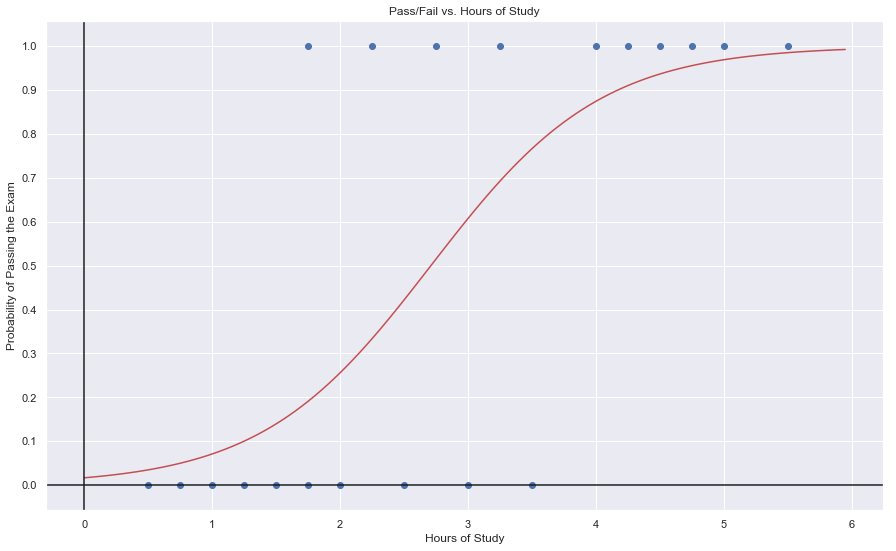

In [22]:
plt.figure(figsize=(15, 9))
sns.set(style='darkgrid')
plt.title('Pass/Fail vs. Hours of Study')
H = np.arange(0.0, 6.0, 0.05)
P = sigmoid(beta + gamma * H)
sns.lineplot(H, P, color='r')
plt.axvline(x=0.0, c='k')
plt.axhline(y=0.0, c='k')
plt.xlabel('Hours of Study')
plt.ylabel('Probability of Passing the Exam')
plt.yticks(np.arange(-0.0, 1.01, step=0.1))
plt.scatter(x, (y + 1) / 2, color='b')
plt.savefig('exam-probability.pdf')